# Disaster tweets

The data used in this example is from Kaggle's Disaster Tweets: https://www.kaggle.com/competitions/nlp-getting-started/overview

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
layers = tf.keras.layers

tweets = pd.read_csv('train.csv')
len(tweets[tweets.target == 0]) / len(tweets), len(tweets[tweets.target == 1]) / len(tweets)

(0.5703402075397347, 0.4296597924602653)

We see that the tweets are pretty balanced. We don't need to do anything here.

In [17]:
X = tweets.text.to_numpy()
y = tweets.target.to_numpy()

X.shape, y.shape

((7613,), (7613,))

A lot of words are too common to matter, so-called stopwords. Typically, we get better results by removing the stopwords. Also removing the hash-tags, since I'm trying to solve it as a natural language problem.

In [18]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

s_words = frozenset(stopwords.words('english'))

def clean(sentence):
  tokens = word_tokenize(sentence)
  tokens = [t.lower() for t in tokens if t not in s_words and not t.startswith('#')]
  return ' '.join(tokens)

X = np.array([clean(x) for x in X])
X[0:10]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\oih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


array(['our deeds reason earthquake may allah forgive us',
       'forest fire near la ronge sask . canada',
       "all residents asked 'shelter place ' notified officers . no evacuation shelter place orders expected",
       '13,000 people receive wildfires evacuation orders california',
       'just got sent photo ruby alaska smoke wildfires pours school',
       'rockyfire update = > california hwy . 20 closed directions due lake county fire - cafire wildfires',
       'flood disaster heavy rain causes flash flooding streets manitou , colorado springs areas',
       "i 'm top hill i see fire woods ...",
       "there 's emergency evacuation happening building across street",
       "i 'm afraid tornado coming area ..."], dtype='<U193')

68


(array([7.440e+02, 2.880e+03, 3.376e+03, 5.370e+02, 5.900e+01, 1.000e+01,
        2.000e+00, 2.000e+00, 2.000e+00, 1.000e+00]),
 array([ 1. ,  7.7, 14.4, 21.1, 27.8, 34.5, 41.2, 47.9, 54.6, 61.3, 68. ]),
 <BarContainer object of 10 artists>)

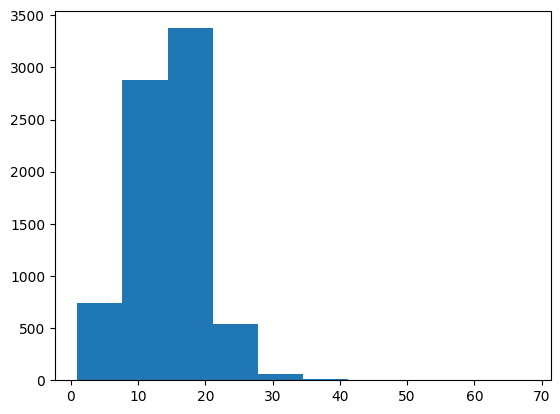

In [19]:
tweet_lengths = [len(word_tokenize(x)) for x in X]
print(np.max(tweet_lengths))
plt.hist(tweet_lengths)

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=504)
X_train, X_test = tf.convert_to_tensor(X_train, dtype=tf.string), tf.convert_to_tensor(X_test, dtype=tf.string)

# Building the model

We'll need an embedding to get a semantic understanding of the words. We can either make a learnable Embedding layer or download a pre-trained one.

Here I'm showing how to use the GloVe embedding. I ended up not using, though.

__Note__: You have to download the embedding yourself. It's over 100MB.

In [21]:
# GloVe = {}

# with open('./glove.6B.50d.txt','r', encoding='UTF-8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vectors = np.asarray(values[1:],'float32')
#         GloVe[word] = vectors
        
# f.close()

# embed_dim = len(GloVe['the'])


In [22]:
def create_embedding_matrix(vocabulary, dim):
  num_words = len(vocabulary)
  embedding_matrix = np.zeros((num_words, dim))

  hits, misses = 0, 0
  for i, word in enumerate(vocabulary):
    if word in GloVe:
      embedding_matrix[i] = GloVe[word]
      hits += 1
    else:
      misses +=1
  
  print(hits, misses)
  return embedding_matrix

The vectorization layer turns input strings into (arbitrary) vectors. It must be the first layer. We adapt it to the input text, so that it learns the words in the corpus. It's a good bet that the words in the corpus are common enough for future tweets.

In [23]:
vocab_size = 5000

vectorization = layers.TextVectorization(max_tokens=vocab_size, output_sequence_length=30)
vectorization.adapt(X)


The first layer after the vectorization is the embedding layer. The embedding layer turns the arbitrary vectors from the vectorization into something meaningful. How? It's learnable.

Note the regularization on the Embedding layer. It has a lot of parameters and is at risk of overfitting (fitting to the training data instead of word meaning).

The actual recurrent part of the network is quite small to combat overfitting.

In [54]:
# embedding_matrix = create_embedding_matrix(vectorization.get_vocabulary(), embed_dim)
# initializer = tf.keras.initializers.Constant(embedding_matrix)

ann = tf.keras.Sequential([
    layers.Input(shape=(1,), dtype='string'),
    vectorization,
    layers.Embedding(vocab_size, 20, mask_zero=True, embeddings_regularizer=tf.keras.regularizers.L1(.01)),
    layers.SimpleRNN(32, recurrent_regularizer='l2'),
    layers.Dense(1, activation='sigmoid')
])
ann.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 30)                0         
 ctorization)                                                    
                                                                 
 embedding_6 (Embedding)     (None, 30, 20)            100000    
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 32)                1696      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 101729 (397.38 KB)
Trainable params: 101729 (397.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
ann.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=.5, min_lr=1e-7)

history = ann.fit(X_train, y_train, epochs = 200, validation_split=.2, callbacks=[lr])


Epoch 1/200
153/153 [==============================] - 3s 8ms/step - loss: 0.7872 - accuracy: 0.6361 - val_loss: 0.7664 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 2/200
153/153 [==============================] - 1s 6ms/step - loss: 0.7684 - accuracy: 0.6369 - val_loss: 0.7686 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 3/200
153/153 [==============================] - 1s 6ms/step - loss: 0.7695 - accuracy: 0.6359 - val_loss: 0.7821 - val_accuracy: 0.6338 - lr: 0.0010
Epoch 4/200
153/153 [==============================] - 1s 6ms/step - loss: 0.7682 - accuracy: 0.6355 - val_loss: 0.7961 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 5/200
153/153 [==============================] - 1s 6ms/step - loss: 0.7699 - accuracy: 0.6351 - val_loss: 0.7592 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 6/200
153/153 [==============================] - 1s 6ms/step - loss: 0.7680 - accuracy: 0.6363 - val_loss: 0.7768 - val_accuracy: 0.6346 - lr: 0.0010
Epoch 7/200
153/153 [==============================] - 1s 7ms/st

# The result

RNNs tend to find these plateaus where it reaches something close to equilibrium, then breaks out of it rapidly. You can see that in the graphs below.

The result is less than optimal. Lots of overfitting happening.

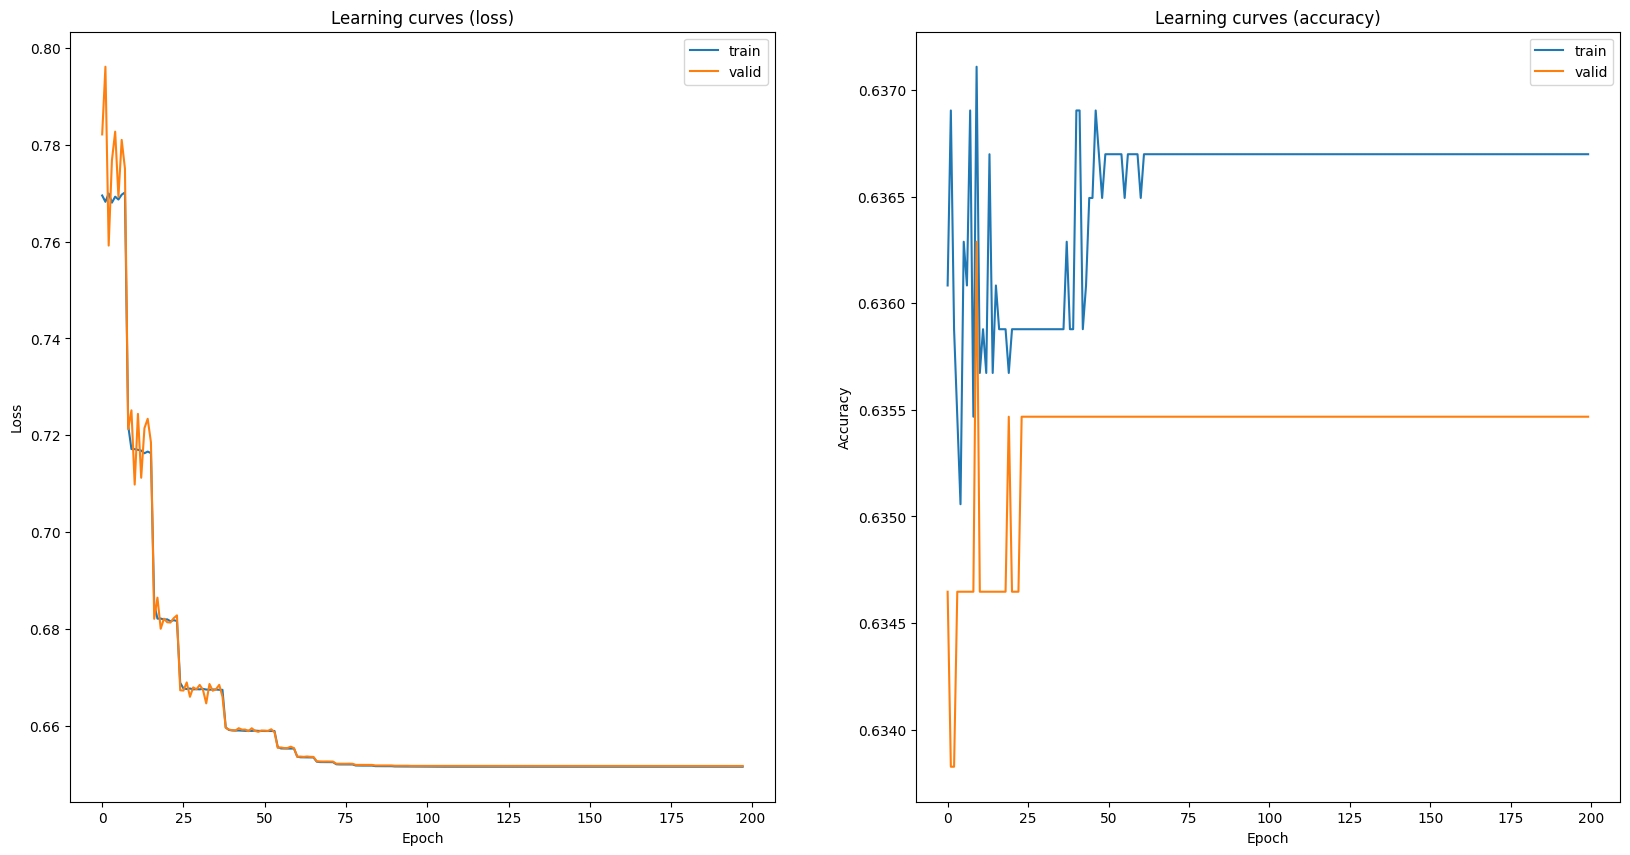

In [59]:
figure = plt.figure(figsize=(20, 10))
ax = figure.add_subplot(1, 2, 1, title='Learning curves (loss)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.plot(history.history['loss'][2:], label = 'train')
ax.plot(history.history['val_loss'][2:], label = 'valid')
ax.legend()

ax = figure.add_subplot(1, 2, 2, title='Learning curves (accuracy)')
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.plot(history.history['accuracy'], label = 'train')
ax.plot(history.history['val_accuracy'], label = 'valid')
ax.legend()

plt.show()

In [60]:
ann.evaluate(X_train, y_train)
ann.evaluate(X_test, y_test)

48/48 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.6257


[0.6595889925956726, 0.6257386803627014]